# Optimization for Machine Learning: Computer Lab 1

## 2. Preprocessing the data

Here, we load the data, standardize it, and set it in the appropriate shape for performing linear regression. You do not need to complete anything in this section; however it is important that you understand what the code is doing. See the pdf instructions for more details.

In [68]:
import numpy as np
import matplotlib.pyplot as plt

In [69]:
# Loading data
data_matrix_train, COP_train, data_matrix_test, COP_test, names = np.load('data_center_data_matrix.npy', allow_pickle=True)

In [70]:
# centering and normalizing the matrix
matrix_mean = np.mean(data_matrix_train, axis=0)
M = data_matrix_train - matrix_mean

matrix_std = np.std(M, axis=0)
M = M / matrix_std

In [71]:
M.shape

(722, 892)

In [72]:
# Building the corresponding matrices A,b for linear regression
A = np.hstack([M, np.ones((M.shape[0],1)), -(M.T * COP_train[:,3]).T])
b = COP_train[:,3]

# Building the same matrices for the test set
M_test = (data_matrix_test - matrix_mean) / matrix_std
A_test = np.hstack([M_test, np.ones((M_test.shape[0],1)), -(M_test.T * COP_test[:,3]).T])
b_test = COP_test[:,3]

d = A.shape[1]

## 3. Ordinary least squares

We now wish to solve the problem
$$
\min_{w \in \mathbb{R}^d} \frac 12 \|Aw-b\|_2^2
$$

## Question 3.1 : 

We have $(Aw)_t = \tilde{x}(t)^Tw_1+w_0-y(t)\times \tilde{x}(t)^Tw_2$ for all $t$ and $b_y = y(t)$

Show that if $Aw = b$, then $y(t) = \frac{w_1^T\tilde{x}(t)+w_0}{w_2^T\tilde{x}(t)+1}$

___

$y(t) = b_t = \tilde{x}(t)^Tw_1 + w_0 - y(t) \times \tilde{x}(t)^Tw_2$

$y(t)[1 + \tilde{x}(t)^Tw_2] = \tilde{x}(t)^Tw_1 + w_0$

If $ 1 + \tilde{x}(t)^Tw_2 \neq 0$ :

$y(t) = \frac{\tilde{x}(t)^Tw_1 + w_0}{1 + \tilde{x}(t)^Tw_2}$

___

## Question 3.2 : 

In [73]:
## Question 3.2: solve with the numpy least squares solver

w_least_squares,_,_,_ = np.linalg.lstsq(A,b)

C:\Users\Arnaud\AppData\Local\Temp\ipykernel_23964\1925269975.py:3: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w_least_squares,_,_,_ = np.linalg.lstsq(A,b)


## Question 3.3 :

In [74]:
## Question 3.3
## NB: np.linalg.norm is the l2 norm

N = A_test.shape[0]
test_error = ( (np.linalg.norm(A_test@w_least_squares - b_test))**2) / N
print("Test error for least squares solution : ", test_error)

Test error for least squares solution :  780.8984793523277


# Question 3.4 : 

### Adding $\ell_2$ regularization

In order to improve the performance on the test set, we add $\ell_2$ regularization:

$$
\min_{w \in \mathbb{R}^d} \frac 12 \|Aw-b\|_2^2 + \frac \lambda 2 \|w\|_2^2
$$ 

where $\lambda = 10^4$

Calculate the gradient of $f_1 (w) = \frac{1}{2}\|Aw-b\|^2 + \frac{\lambda}{2}\|w\|^2$

___

$f_1 (w) = \frac{1}{2}\|Aw-b\|^2 + \frac{\lambda}{2}\|w\|^2$

$f_1 (w) = \frac{1}{2} \langle Aw-b, Aw-b \rangle + \frac{\lambda}{2}\langle w, w \rangle$

$f_1 (w) = \frac{1}{2}(w^TA^T-b^T)(Aw-b) + \frac{\lambda}{2} w^Tw $

$f_1 (w) = \frac{1}{2}(w^TA^TAw-b^TAw-w^TA^Tb + b^Tb) + \frac{\lambda}{2} w^Tw $

$\nabla f_1 (w) = (A^TA+\lambda I_d)w - A^Tb $

___

Is the function convex ?

___

$\nabla^2 f_1 (w) = A^TA+\lambda I_d $

To show that the function $f_1$ is convex, we need to show that for all $x \in \mathbb{R}^d$ :

$x^T \nabla^2 f_1 (w) x \geq 0$

$x^T \nabla^2 f_1 (w) x = x^T (A^TA+\lambda I_d) x = \langle Ax, Ax \rangle + \lambda\langle x, x \rangle$

$x^T \nabla^2 f_1 (w) x = \|Ax\|^2 + \lambda\|x\|^2 \geq 0$

$f_1$ is convex.
___

## Question 3.5 :

Implement gradient descent to minimize $f_1$. What step size are you choosing ? How many iterations are needed to get $w_k$ such that $\|\nabla f(w_k)\| \leq 1$ ?

Step size $\gamma$ computation :

The step size needs to verify to $\gamma \leq \frac{1}{L}$

With $L$ being the Lipschitz constant of $\nabla f_1$

$\|\nabla f_1(x) - \nabla f_1(y)\| = \|(A^TA+\lambda I_d)x - A^Tb - ((A^TA+\lambda I_d)y - A^Tb)\| $

$\|\nabla f_1(x) - \nabla f_1(y)\| = \|(A^TA+\lambda I_d)(x-y)\|$

$\|\nabla f_1(x) - \nabla f_1(y)\| \leq \|(A^TA+\lambda I_d)\| \|(x-y)\|$

We take $\gamma = \|(A^TA+\lambda I_d)\|^{-1}$


In [75]:
lambda_l2 = 1e4

In [76]:
# Question 3.5
def f(w):
    return 0.5*( np.linalg.norm(A@w - b)**2 ) + 0.5*lambda_l2*( np.linalg.norm(w)**2 )

def grad_f(w):
    return np.transpose(A)@(A@w - b) + lambda_l2*w

def gradient_descent(func, w0, gamma, max_iter):
    w = w0.copy()
    f_values = []
    gradient_norms = []
    for t in range(max_iter):
        w = w - gamma*grad_f(w)
        f_values.append(f(w))
        gradient_norms.append(np.linalg.norm(grad_f(w)))
    return w, f_values, gradient_norms

For finding the appropriate step size range, we need to estimate the Lipschitz constant of the gradient.

In [77]:
## Compute the higher eigenvalue to estimate L
L = max( np.linalg.eig(np.transpose(A)@A + lambda_l2*np.eye(d))[0] )
print("Lipschitz constant is :",L)

Lipschitz constant is : (3502543.105358826+0j)


We then chose $\frac{1}{L}$ as the step size.

In [78]:
w0 = np.zeros(d) #arbitrary point to begin the gradient descent
step_size = 1/abs(L)
max_iter = 1000

w_GD, f_values_GD, gradient_norms_GD = gradient_descent(f, w0, step_size, max_iter)

We now compute the evolution of function values and gradient norm. 

Text(0, 0.5, 'Function values')

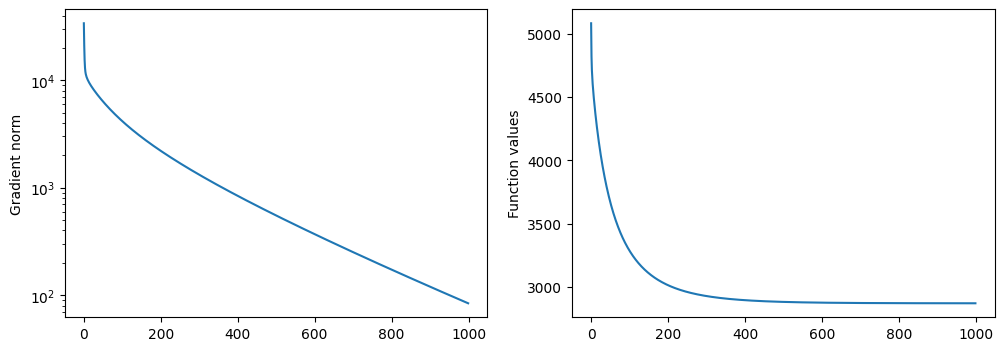

In [79]:
# let us plot the result 
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

axes[0].plot(gradient_norms_GD)
axes[0].semilogy()
axes[0].set_ylabel("Gradient norm")

axes[1].plot(f_values_GD)
axes[1].set_ylabel("Function values")

## Question 3.6 :

We observe that when chosing a good $w0$ and a sufficient amount of iterations, the error for l2 penalized solution is lower than the error we computed with least squares. If we chose $w0$ as np.ones instead of np.zeros, we will see that our algorithm struggles more.

In [80]:
# Question 3.6

test_error_l2 = ( (np.linalg.norm(A_test@w_GD - b_test))**2) / N
print("Test error for l2 penalized solution : ", test_error_l2)

Test error for l2 penalized solution :  59.86398267728799


For a faster algorithm, we could implement accelerated gradient descent.

In [81]:
# Question 3.7 (optional) 

def accelerated_gradient_descent(func, w0, gamma, max_iter):
    x = w0.copy()
    y = w0.copy()
    f_values = []
    gradient_norms = []
    for t in range(max_iter):
        x = y + t*(x-gamma*grad_f(x)-y)/(t+3)
        y = x - gamma*grad_f(x)
        f_values.append(f(y))
        gradient_norms.append(np.linalg.norm(grad_f(y)))
    return x, f_values, gradient_norms

In [82]:
w0 = np.zeros(d) #arbitrary point to begin the gradient descent
step_size = 1/abs(L)
max_iter = 1000
w_AGD, f_values_AGD, gradient_norms_AGD = accelerated_gradient_descent(f, w0, step_size, max_iter)

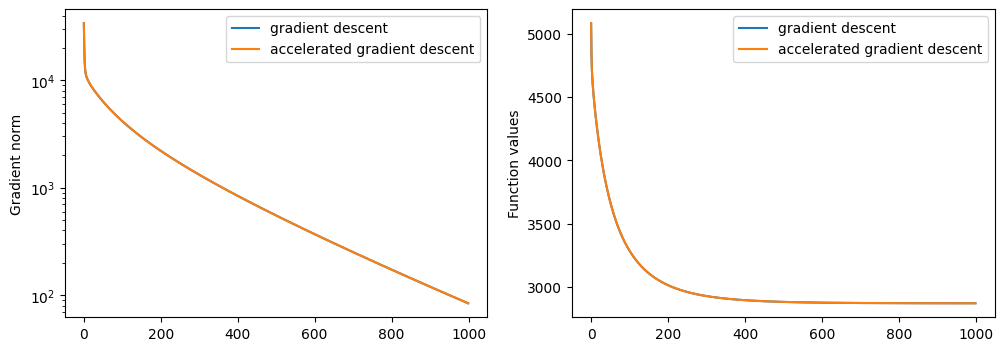

In [83]:
# let us plot the result 
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

axes[0].plot(gradient_norms_GD, label = "gradient descent")
axes[0].plot(gradient_norms_AGD, label = "accelerated gradient descent")
axes[0].semilogy()
axes[0].set_ylabel("Gradient norm")
axes[0].legend()

axes[1].plot(f_values_GD, label = "gradient descent")
axes[1].plot(f_values_AGD, label = "accelerated gradient descent")
axes[1].set_ylabel("Function values")
axes[1].legend()

What do you observe regarding the convergence speed ?

The two methods seem to be converging at the same rate.

## 4. Adding $\ell_1$ regularization (Lasso)

We now solve 

$$
\min_{w \in \mathbb{R}^d} \frac 12 \|Aw-b\|_2^2 + \lambda \|w\|_1
$$

## Question 4.1 :

Write the objective function as $F_2 = f_2 + g_2$ where $f_2$ is differentiable and the proximal operator of $g_2$ is easy to compute. Recall the formula for $prox_{g2}$. Calculate the gradient of $f_2$

___

We have $F_2 = \frac{1}{2}\|Aw-b\|_2^2 + \lambda\|w\|_1$

We know that $\|w\|_1$ is not differentiable on 0, so we identify :

$f_2(w) = \frac{1}{2}\|Aw-b\|_2^2$

$g_2(w) = \lambda\|w\|_1$

___

$prox_{g2}(x) = \argmin_{w \in \mathbb{R}^d} g_2(w) + \frac{1}{2} \|x-w\|^2$

$prox_{g2}(x) = \argmin_{w \in \mathbb{R}^d} \lambda\|w\|_1 + \frac{1}{2} \|x-w\|^2$

To compute $prox_{g2}$, we will use some properties :

If $g_2$ is differentiable at x and convex :

$$\partial {g_2}(x) = {\nabla f(x)}$$

Fermat's rule :

$$p \in \argmin(f) \implies 0 \in \partial {f}(p)$$

We get that (exercise session 3 : proximal gradient descent, exercise 1) :

$prox_{g2}(x) = \sum_{i=1}^{d} prox_{g2}(x_i)e_i$

And :

$prox_{g2}(x_i) = \text{sign}(x_i)\max(0,|x_i|-\lambda)$

___

We now compute the gradient of $f_2$ :

$f_2 (w) = \frac{1}{2}\|Aw-b\|_2^2$

$f_2 (w) = \frac{1}{2} \langle Aw-b, Aw-b \rangle = \frac{1}{2} (w^TA^TAw-b^TAw-w^TA^Tb + b^Tb)$

$\nabla f_2 (w) = A^TAw - A^Tb$

___

## Question 4.2 :


In [97]:
lambda_l1 = 1e3

def l1_norm(x):
    s = 0
    for xi in x:
        s += abs(xi)
    return s

## Question 4.2
def prox_l1(x, mu = 1.):
    #compute the proximal operator of mu * |x|_1
    n = len(x)
    X = np.zeros(n)
    for i in range(n):
        X[i] = np.sign(x[i])* (max(0,abs(x[i]) - (mu) ))
    return X

def proximal_gradient_descent(func, w0, gamma, max_iter):
    w = w0.copy()
    f_values = []
    gradient_norms = []
    for t in range(max_iter):
        w = prox_l1(w-gamma*grad_f(w),lambda_l1*gamma)
        f_values.append(func(w))
        gradient_norms.append(np.linalg.norm(grad_f(w)))    
    return w, f_values, gradient_norms

We take as a stopping criteria the number of iterations.
We could take another criteria like the current norm of the gradient so we stop when the descent is stuck.

## Question 4.3 :

In [98]:
w0 = np.zeros(d) #arbitrary point to begin the gradient descent
step_size = 1/abs(L)
max_iter = 1000

w_PGD, f_values_PGD, gradient_norms_PGD = proximal_gradient_descent(f, w0, step_size, max_iter)

In [99]:
# Question 4.3

test_error_l1 = ( (np.linalg.norm(A_test@w_PGD - b_test))**2) / N
print("Test error for l1 penalized solution : ", test_error_l1)

Test error for l1 penalized solution :  17.452568497241273


The error is reduced compared to the l2 regulation. Thanks to the question 4.1, we can compute the prox fast enough and get a much better result.

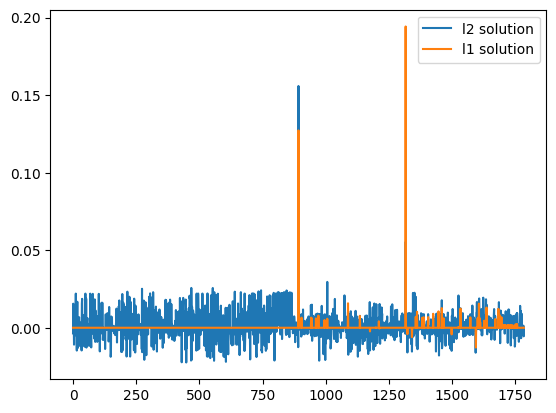

In [100]:
# Let us examine the solution
plt.plot(w_GD, label = "l2 solution")
plt.plot(w_PGD, label = "l1 solution")
plt.legend()

Comparing with the previous test errors. We observe that the l1 solution has much more points equals to $0$. In this example it helps us reduce the error. We see that when necessary, or when the value exceed a certain threshold, l1 fits pretty well the l2 solution.

## Question 4.4 :

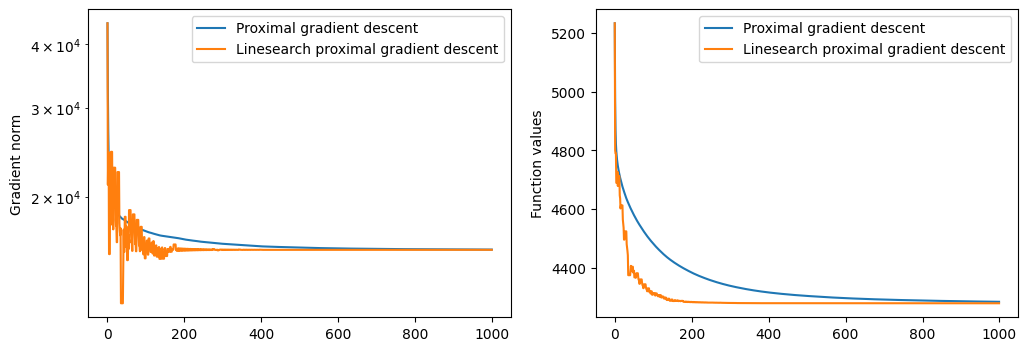

In [102]:
# Question 4.4
def proximal_gradient_descent_linesearch(func, w0, gamma, max_iter):
    w = w0
    f_values = []
    gradient_norms = []
    for k in range(max_iter):
        gradw = grad_f(w)
        wplus = prox_l1(w-gamma*gradw,lambda_l1*gamma)
        if func(wplus) <= func(w) + np.dot(gradw,wplus-w) + (0.5/gamma)*np.linalg.norm(wplus-w)**2 :
            w = wplus
            gamma *= 2
        else:
            gamma *= 0.5
        f_values.append(func(w))
        gradient_norms.append(np.linalg.norm(grad_f(w)))
    return w, f_values, gradient_norms

w0 = np.zeros(d) #arbitrary point to begin the gradient descent
step_size = 1/abs(L)
max_iter = 1000

w_LSD, f_values_LSD, gradient_norms_LSD = proximal_gradient_descent_linesearch(f, w0, step_size, max_iter)


# let us plot the result 
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

axes[0].plot(gradient_norms_PGD, label = "Proximal gradient descent")
axes[0].plot(gradient_norms_LSD, label = "Linesearch proximal gradient descent")
axes[0].semilogy()
axes[0].set_ylabel("Gradient norm")
axes[0].legend()

axes[1].plot(f_values_PGD, label = "Proximal gradient descent")
axes[1].plot(f_values_LSD, label = "Linesearch proximal gradient descent")
axes[1].set_ylabel("Function values")
axes[1].legend()

The linesearch proximal gradient descent is converging faster to the final value. 